# Data Science 1, Winter Semester 2021/22
---
# Exercise Sheet 4: Clustering and Outlier Detection

## a) Visualization

Let's load the dataset, which contains eruption times and waiting times of the [geyser Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful).

In [1]:
from pydataset import data

faithful_df = data('faithful')
faithful_df

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
...,...,...
268,4.117,81
269,2.150,46
270,4.417,90
271,1.817,46


As a side note:
Though the `faithful` dataset might seem rather simple (well, it really is), it was used in the summary chapter of [a dissertation on outlier detection at our chair](https://publikationen.bibliothek.kit.edu/1000120534), which motivated the last two subtasks of this exercise sheet.

Let's summarize the features of the dataset:

In [2]:
faithful_df.describe()

,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


As you can see, the two features are scaled differently, i.e., `waiting` has a wider range.
However, clustering and outlier detection often heavily depend on distance computations.
If features are scaled differently, distance computations are biased towards the attributes with the bigger ranges.
Thus, we should normalize the data:

In [3]:
import pandas as pd
from sklearn.preprocessing import scale

norm_faithful_df = pd.DataFrame(scale(X=faithful_df), columns=faithful_df.columns)
norm_faithful_df.describe().round(2)

,eruptions,waiting
count,272.00,272.00
mean,0.00,0.00
std,1.00,1.00
min,-1.66,-2.06
25%,-1.16,-0.95
50%,0.45,0.38
75%,0.85,0.82
max,1.42,1.85


`scale()` standardizes the data, i.e., each feature has a mean of 0 and a standard deviation of 1 afterwards.
By the way, `sklearn.preprocessing` also contains other scalers (e.g., `MinMaxScaler`).

Let's plot the dataset:

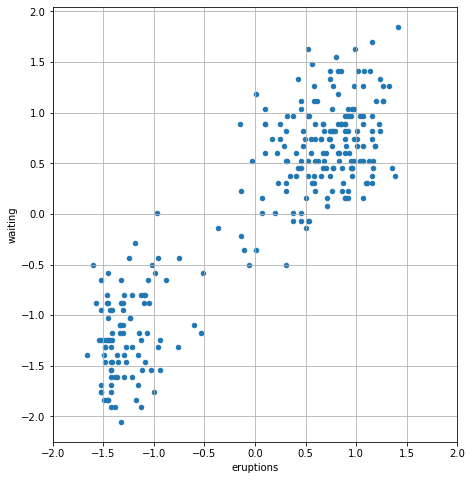

In [4]:
import matplotlib.pyplot as plt
import numpy as np

norm_faithful_df.plot.scatter(x='eruptions', y='waiting', figsize=(8, 8))
plt.grid()
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.yticks(np.arange(-2, 2.5, 0.5))
plt.gca().set_aspect('equal')  # gca() gets Axis to which is plotted at moment
plt.show()

Note that we set the aspect ratio of the axes to 1:1, to represent distances faithfully.

Looks like there are two roughly spherical (or elliptical) clusters.
This is a comparatively easy situation for many standard clustering algorithms.

Let's create histograms to analyze the distributions in detail:

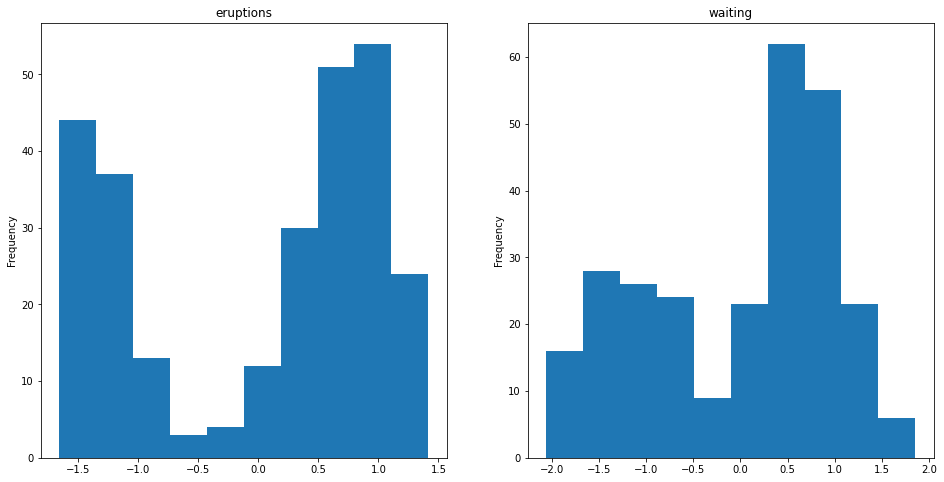

In [5]:
_, axs = plt.subplots(ncols=2, figsize=(16, 8))
for feature, ax in zip(norm_faithful_df.columns, axs):
    norm_faithful_df[feature].plot.hist(ax=ax, title=feature)
plt.show()

For both features, density has two peaks in the cluster centers, but decreases with growing distance from them.
This means the two clusters should also be present if we only clustered on individual features.
(We won't do that in this exercise though.)

Finding proper outliers is more difficult than observing the clusters here.
There are no individual points that are really far away from the rest.
However, some points are relatively far from the cluster centers and from other points.
This may sound a bit fuzzy, and indeed, the definition of "outlierness" is not always clear.
We will discuss this in more detail in subtask e).

Finally, let's have a look at the bivariate density:

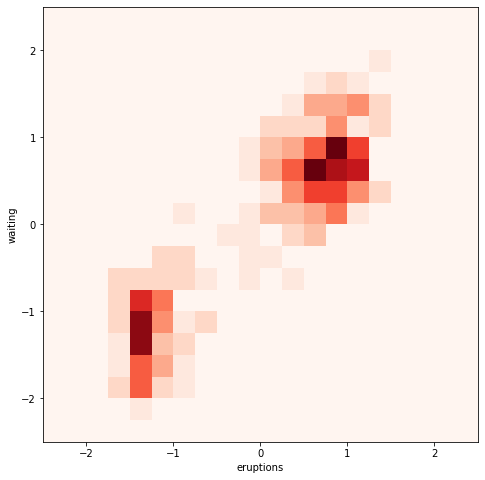

In [6]:
plt.figure(figsize=(8, 8))
plt.hist2d(norm_faithful_df['eruptions'], norm_faithful_df['waiting'], bins=20, range=[(-2.5,2.5)] * 2, cmap='Reds')
plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.gca().set_aspect('equal')
plt.show()

No surprises here.
Again, we see the two clusters.

By the way, the `seaborn` package has several nice options for combined uni- and bivariate plots.
Here are some examples:

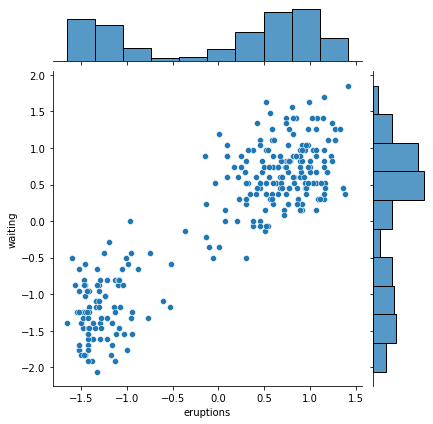

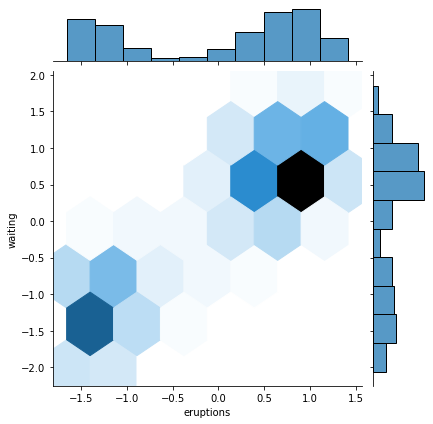

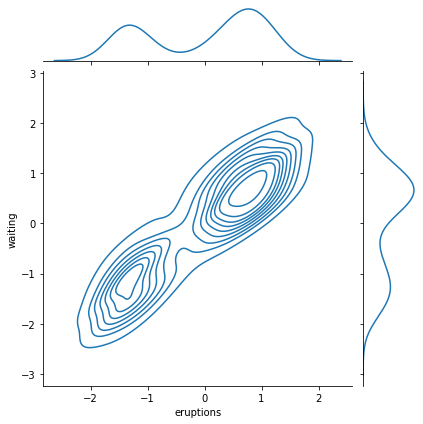

In [7]:
import seaborn as sns

for kind_val in ['scatter', 'hex', 'kde']:
    joint_plot = sns.jointplot(data=norm_faithful_df, x='eruptions', y='waiting', kind=kind_val)
plt.show()

`matplotlib` supports such plots [as well](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html).

## b) K-Means

Before we systematically evaluate different values of *k*, let's see how clustering and silhouette computation work:

In [8]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=25)
kmeans_model.fit(X=norm_faithful_df)
y_pred = kmeans_model.predict(X=norm_faithful_df)

The code looks similar to using a supervised predicting model.
However, note that we don't need to pass a `y` for training with `fit()`.
The "prediction" simply assigns the cluster labels to the points.
We set `random_state`, as the initial positioning of the centroids is non-deterministic.
By default, `KMeans` repeats centroid initialization and clustering ten times (parameter `n_init`).

Let's have a look how the cluster assignments are stored:

In [9]:
y_pred[:10]

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1])

Each cluster is represented by an integer.

We can also retrieve the cluster centers (which we'll use for plotting later):

In [10]:
kmeans_model.cluster_centers_

array([[-1.26008539, -1.20156744],
       [ 0.70970327,  0.67674488]])

Let’s compute the silhouette coefficient:

In [11]:
from sklearn.metrics import silhouette_score

silhouette_score(X=norm_faithful_df, labels=y_pred)

0.7451774401188772

As the silhouette depends on distances between points, you could also set the parameter `metric` to use a particular distance measure.
However, the default, `euclidean`, is fine for us.

By the way, you can also compute the silhouette of each point:

In [12]:
from sklearn.metrics import silhouette_samples

silhouette_array = silhouette_samples(X=norm_faithful_df, labels=y_pred)
print('Some individual silhouettes:', silhouette_array[:10])
print('Overall silhouette:', np.mean(silhouette_array))

Some individual silhouettes: [0.65754514 0.83888584 0.43063115 0.68574112 0.80547175 0.61400522
 0.76714711 0.67406565 0.83888874 0.80475009]
Overall silhouette: 0.7451774401188772


Note that the overall silhouette coefficient is just the mean over the silhouettes of all points.

Now, for evaluating different values of *k*, we use a loop to:
- conduct clustering
- compute the silhouette coefficient
- plot the clustering result, i.e., the cluster assignments of points

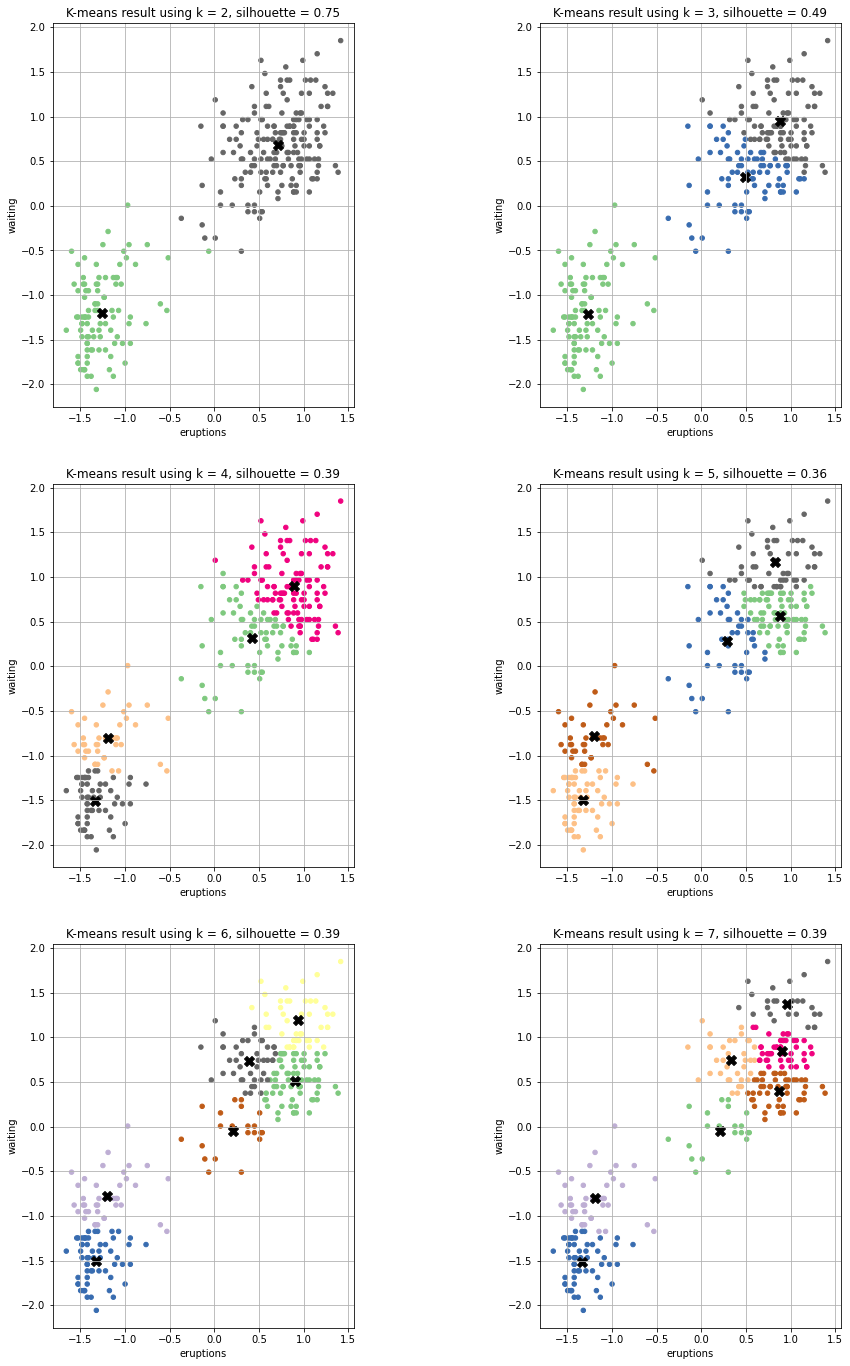

In [13]:
max_k = 7

nrows = int(np.ceil((max_k - 1) / 2))
_, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 8 * nrows))
axs = axs.flatten()
plot_data = norm_faithful_df.copy()

for idx, k in enumerate(range(2, max_k + 1)):
    kmeans_model = KMeans(n_clusters=k, random_state=25)
    kmeans_model.fit(X=norm_faithful_df)
    y_pred = kmeans_model.predict(X=norm_faithful_df)
    silh_score = silhouette_score(X=norm_faithful_df, labels=y_pred)
    
    plot_data['cluster'] = y_pred
    plot_data.plot.scatter(x='eruptions', y='waiting', c='cluster', ax=axs[idx],
                           cmap='Accent', colorbar=False)
    axs[idx].scatter(x=kmeans_model.cluster_centers_[:, 0], y=kmeans_model.cluster_centers_[:, 1],
                     c='black', marker='X', s=100)
    axs[idx].set_title(f'K-means result using k = {k}, silhouette = {silh_score.round(2)}')
    axs[idx].grid()
    axs[idx].set_aspect('equal')

As we assumed, using two clusters yields the most intuitive results on the plots.
One might be unhappy with outlier points (e.g., those in the middle between the clusters) being also assigned to clusters, but most clustering algorithms do that.

Using two clusters does not only look good, but also results in the highest value of the silhouette coefficient.
Thus, the silhouette coefficient, and other measures for cluster quality (see [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster) what `sklearn` offers), can help to determine hyperparameters of clustering algorithms.
Of course, this assumes the clustering-quality measure is aligned to the objective of the clustering algorithm.
In that regard, silhouette coefficient and k-means are a suitable combination.

With higher k, the existing clusters are split up into roughly spherical, roughly equal-sized clusters.
This is related to the objective function of k-means.
Thus, if clusters should have a different shape, then k-means might not be suitable.

## c) DBSCAN

Let's start DBSCAN with some arbitrary hyperparameter values right away:

In [14]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.1, min_samples=5)
dbscan_model.fit(X=norm_faithful_df)
print('Cluster membership frequencies:')
pd.Series(dbscan_model.labels_).value_counts().sort_index()

Cluster membership frequencies:


-1    126
 0     42
 1     71
 2      6
 3      7
 4      6
 5      6
 6      4
 7      4
dtype: int64

The cluster assignments include eight proper clusters (values 0 through 7) and a group of samples deemed to be noise (-1), which is the largest group here.
Thus, while writing the code to run DBSCAN is equally simple as for k-means, choosing its parameters, in particular `eps`, is quite tricky.

Let's plot the cluster assignments:

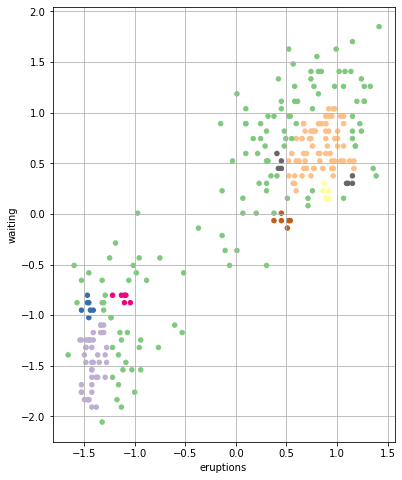

In [15]:
plot_data = pd.concat([norm_faithful_df, pd.Series(dbscan_model.labels_, name='cluster')], axis='columns')
plot_data.plot.scatter(x='eruptions', y='waiting', c='cluster',
                       figsize=(8, 8), cmap='Accent', colorbar=False)
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

In our plot, we clearly see the high amount of noise points.
They do not only occur between the two natural clusters, but also near the border of the natural clusters.
Also, the true clusters are split up into multiple sub-clusters, due to our density settings.

In general, the silhouette coefficient is not a good measure for density-based clustering.
Silhouette considers distances within clusters and between clusters.
In contrast, density-based clustering finds clusters of arbitrary shape, as long as they meet the density requirements.
Thus, distance within clusters can be rather high.
However, in our case, we know that the silhouette coefficient is able to describe quality of the true clusters in the data quite well.
Thus, we can search for a good parametrization of DBSCAN with the silhouette coefficient in a grid-search approach:

In [16]:
best_eps = None
best_min_samples = None
best_sil = -1

for eps in [0.01 * 2**exp for exp in range(1, 21)]:
    for min_samples in range(1, 11):
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_model.fit(X=norm_faithful_df)
        if len(np.unique(dbscan_model.labels_)) >= 2:
            current_sil = silhouette_score(X=norm_faithful_df, labels=dbscan_model.labels_)
            if current_sil > best_sil:
                best_sil = current_sil
                best_eps = eps
                best_min_samples = min_samples

We use a linear range for `min_samples` and an exponential range for `eps`.
Further, the question arises what we should do with noise points in the silhouette computation.
Here, we treat all noise points as belonging to the same cluster (with label `-1`).
As widespread noise clusters will result in bad silhouette values, we thereby hope to reduce the number of noise points altogether.
We also need to handle the case that the silhouette is undefined, which happens if all points are in one cluster (may it be noise, may it be a regular cluster).
Here, we just ignore these cases (and hope that the search finds at least one clustering with at least two clusters).

Let's cluster with the best hyperparameters from the search:

Cluster membership frequencies:
-1      3
 0    173
 1     96
dtype: int64


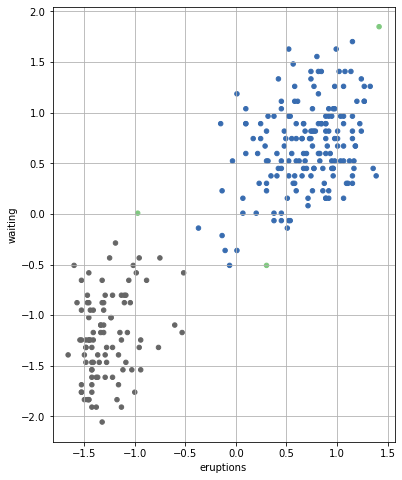

In [17]:
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_model.fit(X=norm_faithful_df)

print('Cluster membership frequencies:')
print(pd.Series(dbscan_model.labels_).value_counts().sort_index())

plot_data = pd.concat([norm_faithful_df, pd.Series(dbscan_model.labels_, name='cluster')], axis='columns')
plot_data.plot.scatter(x='eruptions', y='waiting', c='cluster',
                       figsize=(8, 8), cmap='Accent', colorbar=False)
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

Quite good!
We get two clusters and a few outlier points.

## d) OPTICS

For OPTICS, we only need to specify `min_samples`.
We could also provide an upper bound for `eps`, called `max_eps`, to speed up computation, but our dataset is small anyway.
By default, `max_eps` is equal to infinity.

In [18]:
from sklearn.cluster import OPTICS

optics_model = OPTICS(min_samples=5)
optics_model.fit(X=norm_faithful_df)

OPTICS()

According to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html), the resulting model contains reachability distances in `reachability_` and the order of the points in `ordering_`.
For plotting, we order reachability distances accordingly:

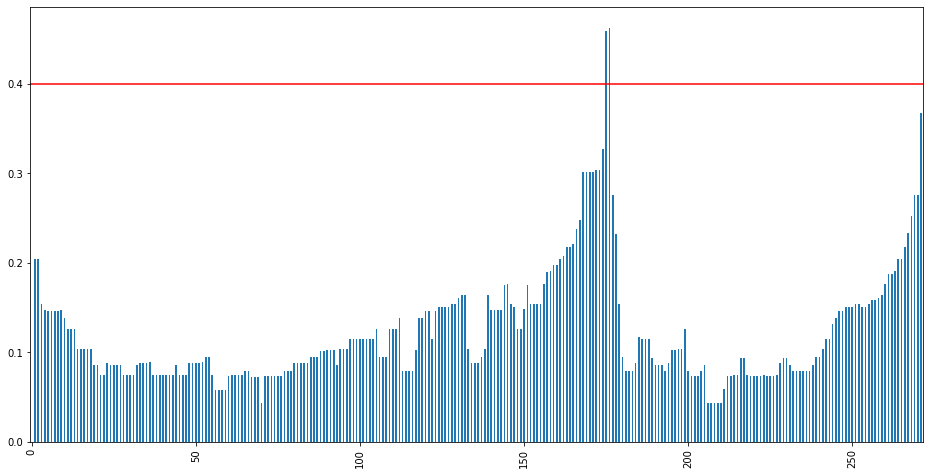

In [19]:
reachabilities = pd.Series(optics_model.reachability_).iloc[optics_model.ordering_]
reachabilities.plot.bar(xticks=range(0, 300, 50), figsize=(16, 8))
plt.axhline(y=0.4, color='red')
plt.show()

This helps to determine a suitable `eps`.
With a value of 0.4, we should get two large clusters, which are separated by a high reachability distance:

Cluster membership frequencies:
0    175
1     97
dtype: int64


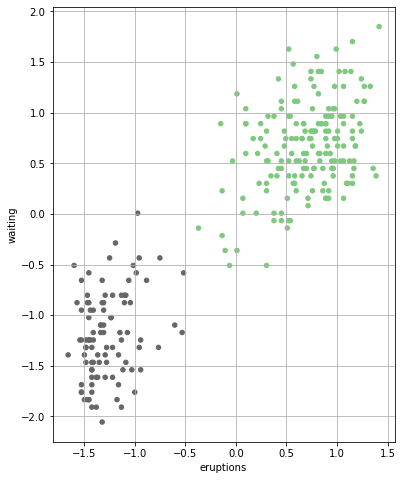

In [20]:
optics_model = OPTICS(min_samples=5, max_eps=0.4, cluster_method='dbscan')
optics_model.fit(X=norm_faithful_df)

print('Cluster membership frequencies:')
print(pd.Series(optics_model.labels_).value_counts().sort_index())

plot_data = pd.concat([norm_faithful_df, pd.Series(optics_model.labels_, name='cluster')], axis='columns')
plot_data.plot.scatter(x='eruptions', y='waiting', c='cluster',
                       figsize=(8, 8), cmap='Accent', colorbar=False)
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

Well, that worked out as intended.
So, by using OPTICS, we found a good value of `eps` for a given value of `min_samples`.
As you also saw, we can extract `DBSCAN` clusters with `OPTICS()` by setting `cluster_method='dbscan'`.

## e) Outlier Detection

As we noted in subtask a), there clearly are points with a rather high distance to the cluster centers, but saying if they really are outliers is trickier.
Different outlier-detection approaches try to formally capture notions of "outlierness" in different ways.
However, there remains the challenge of finding a suitable threshold:
When is a point an inlier and when is it an outlier?
The definition might depend on the use case rather than some fixed statistical boundaries.
As a remedy, many outlier detection algorithms do not return a binary decision, but a continuous outlier score.
This allows moving the threshold flexibly.

We will extract an array of outlier scores for both outlier-detection approaches proposed in the task. 
To ease plotting later, we define a function for creating a scatter plot with outliers highlighted:

In [21]:
from sklearn.preprocessing import MinMaxScaler

def plot_outliers(scores, ax, title):
    scaler = MinMaxScaler(feature_range=(10,500))
    scores = scaler.fit_transform(X=pd.DataFrame(data=scores))
    scores = pd.DataFrame(data=scores, columns=['score'])
    plot_data = pd.concat([norm_faithful_df, scores], axis='columns')
    plot_data.plot.scatter(x='eruptions', y='waiting',  c='score', s='score',
                           ax=ax, cmap='Reds', colorbar=False)
    ax.set_title(title)
    ax.grid()
    ax.set_aspect('equal')

We use the parameters `c` for "color" and `s` for "size" to style points based on their outlier score.
Beforehand, we linearly transform the outlier scores to make the differences in point size prominent in the plot.

Next, we prepare the outlier scores based on kNN and on LOF:

In [22]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(X=norm_faithful_df)
knn_dists, _ = knn_model.kneighbors(X=norm_faithful_df)
knn_scores = knn_dists.mean(axis=1)

`kneighbors()` returns indices of and distances to all *k* neighbors of each point.
We are only interested in the mean distance for each point.

In [23]:
from sklearn.neighbors import LocalOutlierFactor

lof_model = LocalOutlierFactor(n_neighbors=5)
lof_model.fit(X=norm_faithful_df)
lof_scores = (lof_model.negative_outlier_factor_ * -1)

The outlier factors extracted from `LocalOutlierFactor` are negative (as you can tell from the attribute name `negative_outlier_factor_`), so we simply multiply with -1.

Let's plot the scores:

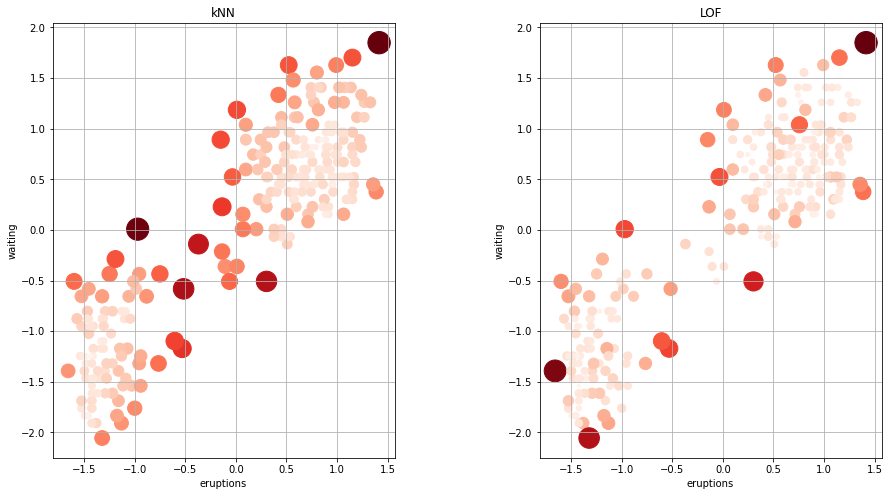

In [24]:
_, axs = plt.subplots(ncols=2, figsize=(16, 8))
plot_outliers(scores=knn_scores, ax=axs[0], title='kNN')
plot_outliers(scores=lof_scores, ax=axs[1], title='LOF')
plt.show()

We can see some commonalities and some differences between the results of the two outlier-detection approaches.
For example, points in the centers of the clusters generally have low outlier scores.
The top-right-most point has a high outlier score for both approaches.

In contrast, several points in the region between the clusters (around (0,-0.5)) have a high outlier score for kNN, but a low score for LOF.
These points are in a region of low density, with comparatively high distances to nearest neighbors.
For kNN, only the distance in absolute terms matters, and the same distance scale is considered globally.
For LOF, points that have not only a high kNN distance, but also neighbors with a high kNN distance, get a comparatively low score.
This means the local situation plays a bigger role.

In the bottom-left corner, you can see two points with high LOF score, but medium kNN score.
For kNN, these points clearly have a higher kNN distance than points in the cluster center.
However, they are not far off from the (imaginary) cluster border, resulting in a comparatively low outlier score.
For LOF, the neighbors of these points have a clearly lower distance to their neighbors, because they are closer to the center.
Thus, the LOF score of the two points under discussion is rather high.

## f) Subspace Outliers

We repeat the procedure as before (only for kNN, not for LOF) with different subsets of the data:

In [25]:
# Outlier scores for 'eruptions':
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(X=norm_faithful_df['eruptions'].to_frame())
knn_eruptions_dists, _ = knn_model.kneighbors(X=norm_faithful_df['eruptions'].to_frame())
knn_eruptions_scores = knn_eruptions_dists.mean(axis=1)

# Outlier scores for 'waiting':
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(X=norm_faithful_df['waiting'].to_frame())
knn_waiting_dists, _ = knn_model.kneighbors(X=norm_faithful_df['waiting'].to_frame())
knn_waiting_scores = knn_waiting_dists.mean(axis=1)

# Outlier scores for full space:
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(X=norm_faithful_df)
knn_full_dists, _ = knn_model.kneighbors(X=norm_faithful_df)
knn_full_scores = knn_full_dists.mean(axis=1)

To ease comparison, we create a grid with univariate outlier scores, bivariate outlier scores and bivariate density.

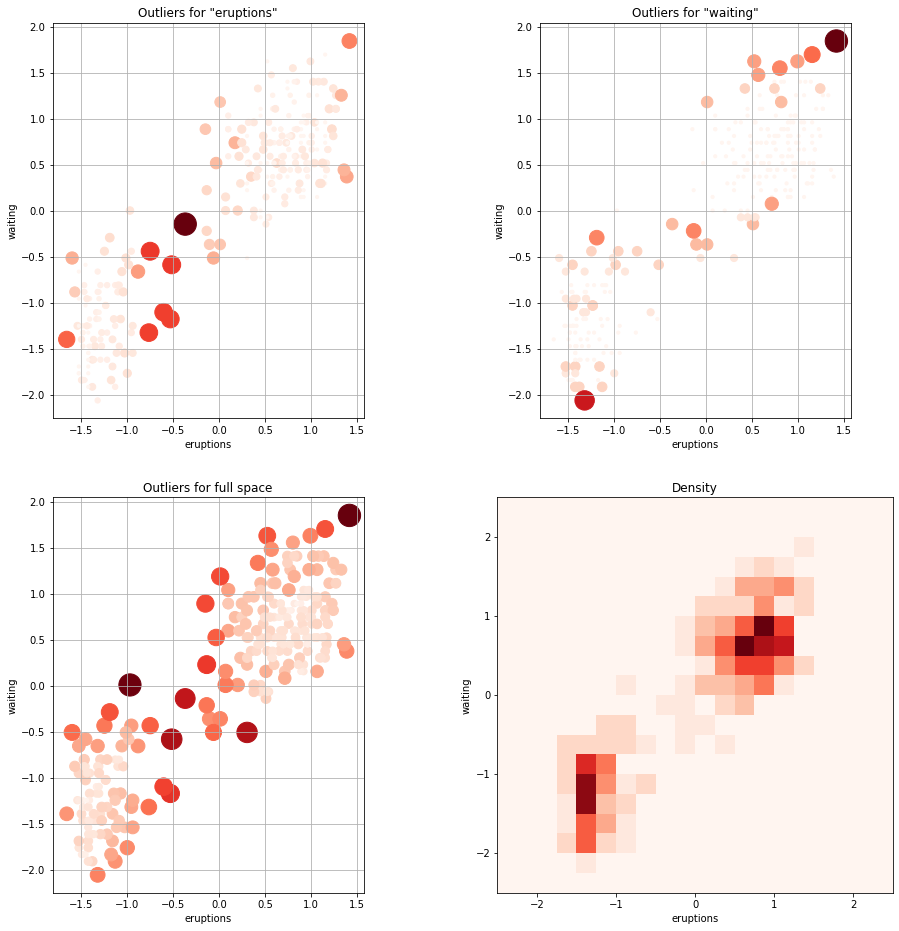

In [26]:
_, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = axs.flatten()

plot_outliers(scores=knn_eruptions_scores, ax=axs[0], title='Outliers for "eruptions"')
plot_outliers(scores=knn_waiting_scores, ax=axs[1], title='Outliers for "waiting"')
plot_outliers(scores=knn_full_scores, ax=axs[2], title='Outliers for full space')

axs[3].hist2d(norm_faithful_df['eruptions'], norm_faithful_df['waiting'], bins=20, range=[(-2.5,2.5)] * 2, cmap='Reds')
axs[3].set_title('Density')
axs[3].set_xlabel('eruptions')
axs[3].set_ylabel('waiting')
axs[3].set_aspect('equal')

plt.show()

There definitely are points whose outlier score differs between subspaces.
For example, the points with the lowest and highest waiting times have a very high outlier score regarding `waiting`, but a lower score regarding `eruptions`.
Also, there is a point in the middle at roughly (-0.4, -0.1) that is quite outlying regarding `eruptions` (it is the only point in some “vertical corridor” around it), but rather normal regarding `waiting` (there are some other points in some “horizontal corridor” around it).
There are also non-trivial outliers.
For example, the point at roughly (-1, 0) is perfectly normal in either one-dimensional space, but has a high outlier score in the two-dimensional space.